In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
teamexp = pd.read_csv("/Users/olivianewton/Documents/Manuscripts/TopiCS_SpecialIssue/team_expertise_info_raw.csv")

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


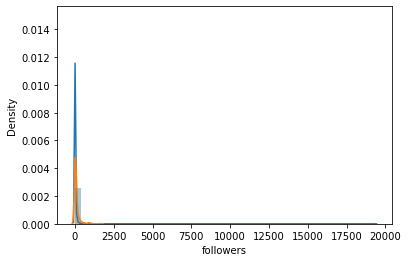

In [3]:
ax = sns.distplot(teamexp[teamexp['Team type'] == 'human']['followers'])
ax = sns.distplot(teamexp[teamexp['Team type'] == 'human-bot']['followers'])

In [4]:
teamexp[teamexp['Team type'] == 'human'].mean()

followers                   27.885087
following                   62.573959
follower_following_ratio     2.105902
public_repos                82.092808
gh_impact                    2.373707
dtype: float64

In [5]:
teamexp[teamexp['Team type'] == 'human-bot'].mean()

followers                    96.457237
following                   361.003289
follower_following_ratio      5.505310
public_repos                635.628289
gh_impact                    10.325658
dtype: float64

In [6]:
from sklearn.preprocessing import StandardScaler
# print(teamexp.columns)
scaler = StandardScaler()
cols_to_normalize = ['followers', 'following', 'public_repos', 'gh_impact']
X = scaler.fit_transform(teamexp[cols_to_normalize])
normalized_teams = pd.DataFrame(data=X, index=teamexp['name_h'], columns=cols_to_normalize)
normalized_teams.reset_index(inplace=True)
temp = teamexp[['name_h', 'Team type']]
# print(temp.columns, normalized_teams.columns)
normalized_teams = normalized_teams.merge(temp, on='name_h')
normalized_teams.head()

,name_h,followers,following,public_repos,gh_impact,Team type
0,--iqCZE8ygTIzjke0InO_w/DsUJjAzSrZHpyQzkVmwf4A,0.049545,-0.051899,0.054834,-0.088738,human
1,--ynbYaQNUt9ObdPSaKAAA/ucOcrZ9PVv51EXaDXBXtQg,-0.142170,-0.133479,-0.100982,-0.268420,human
2,-0K4o6gTtkvDYvsNJiOeEA/neOX4u0j5t1dnkldD8zuiw,-0.009444,-0.091694,-0.000705,-0.268420,human
3,-0Pr09MJXbjkm0S0aFgwSQ/clNeEOtjeVxUV04F0zbomQ,-0.142170,-0.133479,-0.122580,-0.448102,human
4,-0TJRtTYq1YTWD0Yrm1R0Q/bm3dfy4XVfvaLJYBR_P5_A,-0.132339,-0.131489,-0.087098,-0.268420,human


In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
# normalized_teams.set_index('name_h', inplace=True)
X = normalized_teams
coltore = ['Team type', 'name_h']
print(X.columns)
X_hb = X[X['Team type'] == 'human-bot']
X_h = X[X['Team type'] == 'human']
# nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(X_h.drop(coltore, axis=1))
human_teams = X_h.set_index('name_h').drop('Team type', axis=1).copy(deep=True)
selected_teams = []
for i, row in X_hb.drop(coltore, axis=1).iterrows():
    distances = euclidean_distances(row.values.reshape(1, -1), human_teams)
    min_idx = np.argmin(distances)
    closest_team = human_teams.index.tolist()[min_idx]
    selected_teams.append(closest_team)
    human_teams.drop(closest_team, inplace=True)
#     print(human_teams.shape)

Index(['name_h', 'followers', 'following', 'public_repos', 'gh_impact',
       'Team type'],
      dtype='object')


In [9]:
X_h.reset_index(inplace=True)
X_h_downsampled = X_h[X_h['name_h'].isin(selected_teams)]
print(X_h_downsampled.shape, X_h_downsampled.columns)

(304, 7) Index(['index', 'name_h', 'followers', 'following', 'public_repos',
       'gh_impact', 'Team type'],
      dtype='object')


In [10]:
X_h_downsampled.mean()

index           10518.000000
followers           0.321481
following           0.624282
public_repos        0.374011
gh_impact           1.355810
dtype: float64

In [11]:
X_hb.mean()

followers       0.331992
following       0.584827
public_repos    0.841052
gh_impact       1.407232
dtype: float64

In [12]:
X_h_downsampled['name_h'].to_csv("/Users/olivianewton/Documents/Manuscripts/TopiCS_SpecialIssue/Human_Teams_SmartSampled.csv", index=False)